In [1]:
# Import Statements
import sys
import os
import importlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr

# Custom Module Setup
sys.path.append('/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/')
from ESMCBA.imports import *
from ESMCBA import graph_utils
from ESMCBA import other_utils
importlib.reload(other_utils)


<module 'ESMCBA.other_utils' from '/global/scratch/users/sergiomar10/ESMCBA/ESMCBA/ESMCBA/other_utils.py'>

In [2]:

# Suppress Warnings
warnings.filterwarnings('ignore')

# Load Data
predictions = pd.read_csv('../performances/model_predictions_by_HLA_21032025.csv')

# Constants
FEATURES = ['prediction', 'netmhc_log', 'mhc_log']
TARGET = 'measured'


In [3]:

# Data Preparation and Modeling Functions
def prepare_data(df, allele):
    """Prepare data for modeling by filtering for a specific allele and splitting into train/val/test sets.
    
    Args:
        df (pd.DataFrame): Input DataFrame with predictions and measured values.
        allele (str): HLA allele to filter by (e.g., 'HLA-A1101').
    
    Returns:
        tuple: Scaled X_train, X_val, X_test, y_train, y_val, y_test, scaler, and test indices.
    """
    allele_df = df[df['allele'] == allele].copy()
    X = allele_df[FEATURES]
    y = allele_df[TARGET]
    
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler, X_test.index

def create_ensemble_models():
    """Create a dictionary of ensemble models for stacking.
    
    Returns:
        dict: Dictionary of ensemble model names and their configurations.
    """
    base_estimators = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('ada', AdaBoostRegressor(n_estimators=100, random_state=42))
    ]
    
    return {
        'Stacking_RF_GB': StackingRegressor(estimators=base_estimators[:2], final_estimator=LinearRegression()),
        'Stacking_RF_ADA': StackingRegressor(estimators=[base_estimators[0], base_estimators[2]], final_estimator=LinearRegression()),
        'Stacking_ALL': StackingRegressor(estimators=base_estimators, final_estimator=LinearRegression())
    }

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """Train and evaluate a model, returning performance metrics.
    
    Args:
        model: Scikit-learn model instance.
        X_train, X_val, X_test: Feature arrays for training, validation, and test sets.
        y_train, y_val, y_test: Target arrays for training, validation, and test sets.
    
    Returns:
        dict: Metrics including MSE, R², Spearman, and Pearson correlations.
        np.ndarray: Predictions on the test set.
    """
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return {
        'MSE_Val': mean_squared_error(y_val, y_pred_val),
        'MSE_Test': mean_squared_error(y_test, y_pred_test),
        'R2_Test': r2_score(y_test, y_pred_test),
        'Spearman': spearmanr(y_test, y_pred_test)[0],
        'Pearson': pearsonr(y_test, y_pred_test)[0]
    }, y_pred_test

def process_allele(df, allele):
    """Process data and train ensemble models for a specific allele.
    
    Args:
        df (pd.DataFrame): Input DataFrame with predictions and measured values.
        allele (str): HLA allele to process.
    
    Returns:
        dict: Performance results for the allele.
        pd.DataFrame: Predictions for the test set.
    """
    X_train, X_val, X_test, y_train, y_val, y_test, _, test_idx = prepare_data(df, allele)
    ensemble_models = create_ensemble_models()
    
    results = {'Allele': allele}
    predictions_dict = {}
    
    for model_name, model in ensemble_models.items():
        metrics, y_pred_test = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
        results.update({f'{model_name}_{k}': v for k, v in metrics.items()})
        predictions_dict[model_name] = y_pred_test
    
    pred_df = pd.DataFrame({
        'Sequence': df.loc[test_idx, 'sequence'],
        'True_Value': y_test,
        **predictions_dict
    })
    pred_df['Allele'] = allele
    
    return results, pred_df

# Main Processing Loop
def process_all_alleles(df):
    """Process all unique alleles in the dataset and compile results.
    
    Args:
        df (pd.DataFrame): Input DataFrame with predictions and measured values.
    
    Returns:
        pd.DataFrame: Compiled results for all alleles.
        pd.DataFrame: Combined predictions for all alleles.
    """
    unique_alleles = df['allele'].unique()
    all_results = []
    all_predictions = []
    
    for allele in unique_alleles:
        result, pred_df = process_allele(df, allele)
        all_results.append(result)
        all_predictions.append(pred_df)
    
    results_df = pd.DataFrame(all_results).round(3)
    column_order = ['Allele'] + [col for col in results_df.columns if col != 'Allele']
    results_df = results_df[column_order]
    
    combined_predictions = pd.concat(all_predictions, ignore_index=True)
    return results_df, combined_predictions

# Visualization Functions
def plot_scatter_matrix(data, model_cols):
    """Generate a scatter plot matrix of predictions vs true values."""
    plt.figure(figsize=(15, 10))
    for i, model in enumerate(model_cols, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(data=data, x='True_Value', y=model, alpha=0.5)
        plt.plot([0, 6], [0, 6], 'r--', alpha=0.5)
        plt.title(f'{model} vs True Value')
        plt.xlabel('Measured Log10(IC50) (nM)')
        plt.ylabel('Predicted Log10(IC50) (nm)')
        plt.ylim(-1, 6)
        plt.xlim(-1, 6)
    plt.tight_layout()
    plt.savefig('scatter_matrix.png')
    plt.show()

def plot_error_distributions(data, model_cols):
    """Generate error distribution plots for each model."""
    plt.figure(figsize=(15, 5))
    for i, model in enumerate(model_cols, 1):
        plt.subplot(2, 3, i)
        errors = data[model] - data['True_Value']
        sns.histplot(errors, bins=30, kde=True)
        plt.title(f'{model} Error Distribution')
        plt.xlabel('Prediction Error')
    plt.tight_layout()
    plt.savefig('error_distributions.png')
    plt.show()

def plot_correlation_heatmap(data, model_cols):
    """Generate a correlation heatmap between predictions and true values."""
    plt.figure(figsize=(10, 8))
    correlation_matrix = data[['True_Value'] + model_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Predictions and Measured Binding Affinities')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

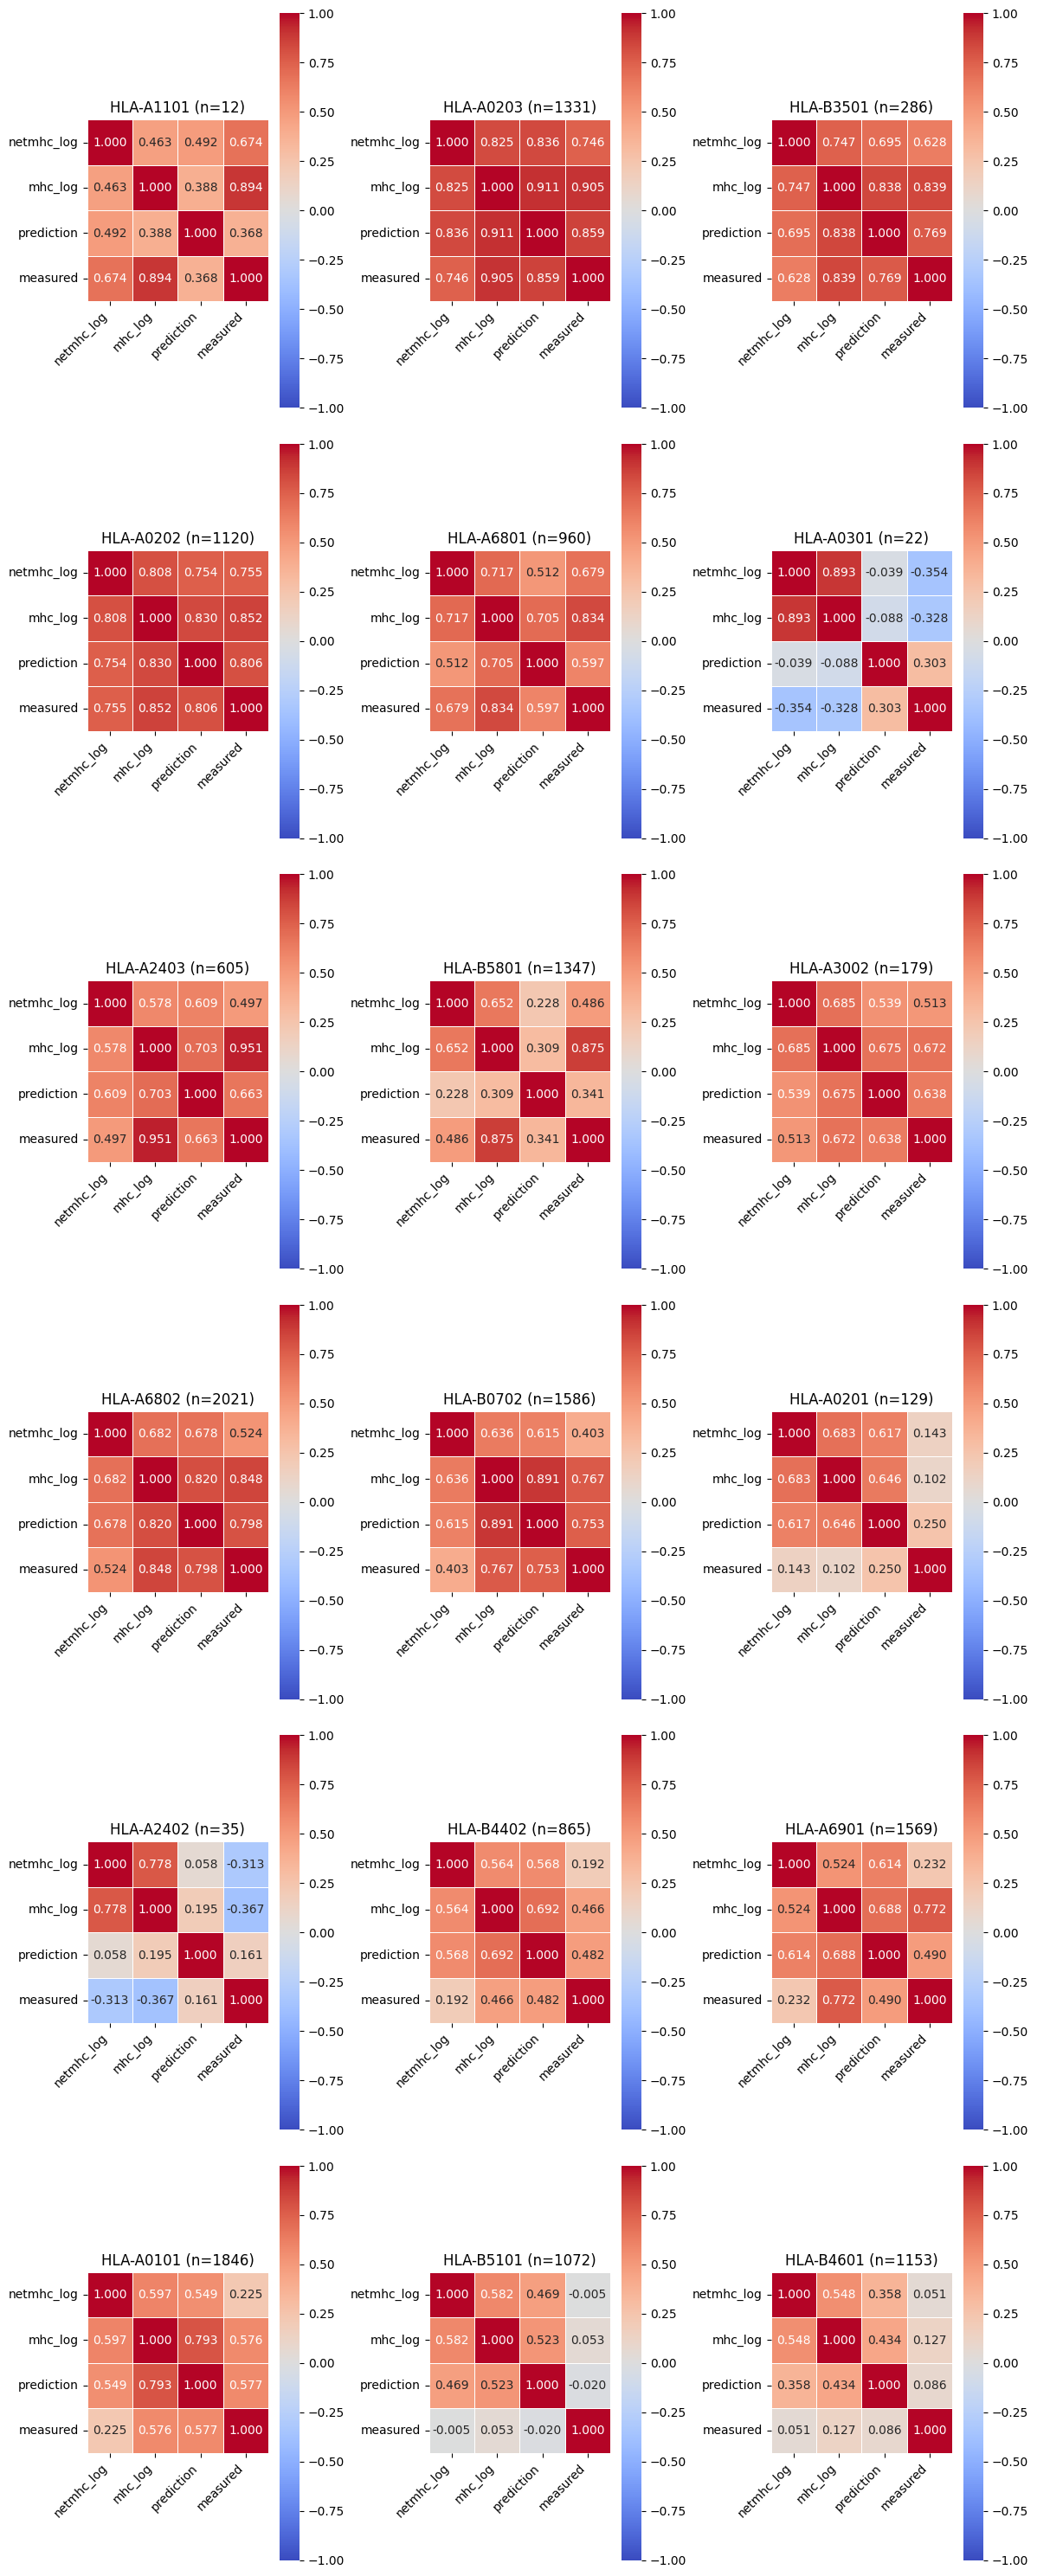

In [15]:
# Columns of interest
columns_of_interest = ['netmhc_log', 'mhc_log', 'prediction', 'measured']

# Get unique HLA alleles
alleles = predictions['allele'].unique()

# Set up the subplot grid
n_alleles = len(alleles)
cols = 3  # Number of columns in the subplot grid
rows = (n_alleles + cols - 1) // cols  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows), squeeze=False)
axes = axes.flatten()  # Flatten for easy indexing

# Plot correlation matrix for each allele
for i, allele in enumerate(alleles):
    # Subset data for the current allele
    subset = predictions[predictions['allele'] == allele]
    n_points = len(subset)
    
    # Compute correlation matrix for this allele
    corr_matrix = subset[columns_of_interest].corr(method='pearson')
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                vmin=-1, vmax=1, 
                center=0, 
                square=True, 
                linewidths=0.5, 
                fmt='.3f',
                ax=axes[i])
    
    # Customize the subplot
    axes[i].set_title(f'{allele} (n={n_points})')
    
    # Adjust tick labels for readability
    axes[i].set_xticklabels(columns_of_interest, rotation=45, ha='right')
    axes[i].set_yticklabels(columns_of_interest, rotation=0)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [4]:
results_df, combined_predictions = process_all_alleles(predictions)

# Merge and rename for visualization
plot_data = pd.merge(
    combined_predictions,
    predictions[['sequence', 'allele', 'prediction', 'netmhc_log', 'mhc_log']],
    left_on=['Sequence', 'Allele'], right_on=['sequence', 'allele'],
    how='left'
).rename(columns={
    'prediction': 'Fine-tuned_ESM',
    'netmhc_log': 'NetMHC',
    'mhc_log': 'MHC_Flurry',
    'Stacking_RF_GB': 'Ensemble_RF_GB',
    'Stacking_RF_ADA': 'Ensemble_RF_ADA',
    'Stacking_ALL': 'Ensemble_ALL'
})

model_cols = ['Fine-tuned_ESM', 'NetMHC', 'MHC_Flurry', 'Ensemble_RF_GB', 'Ensemble_RF_ADA', 'Ensemble_ALL']

# Output results
print("\nEnsemble Model Performance by HLA Allele:")
print(results_df.to_string(index=False))
print("\nSample of Predictions:")
print(combined_predictions.head().to_string(index=False))

# Save to CSV
results_df.to_csv('ensemble_results_by_allele.csv', index=False)
combined_predictions.to_csv('ensemble_predictions.csv', index=False)



Ensemble Model Performance by HLA Allele:
   Allele  Stacking_RF_GB_MSE_Val  Stacking_RF_GB_MSE_Test  Stacking_RF_GB_R2_Test  Stacking_RF_GB_Spearman  Stacking_RF_GB_Pearson  Stacking_RF_ADA_MSE_Val  Stacking_RF_ADA_MSE_Test  Stacking_RF_ADA_R2_Test  Stacking_RF_ADA_Spearman  Stacking_RF_ADA_Pearson  Stacking_ALL_MSE_Val  Stacking_ALL_MSE_Test  Stacking_ALL_R2_Test  Stacking_ALL_Spearman  Stacking_ALL_Pearson
HLA-A1101                  23.533                   25.601               -3153.012                    0.500                   0.541                  152.550                    92.411               -11384.131                    -0.500                   -0.374                43.713                  7.752              -954.100                  0.500                -0.303
HLA-A0203                   0.299                    0.409                   0.875                    0.825                   0.936                    0.300                     0.407                    0.876        

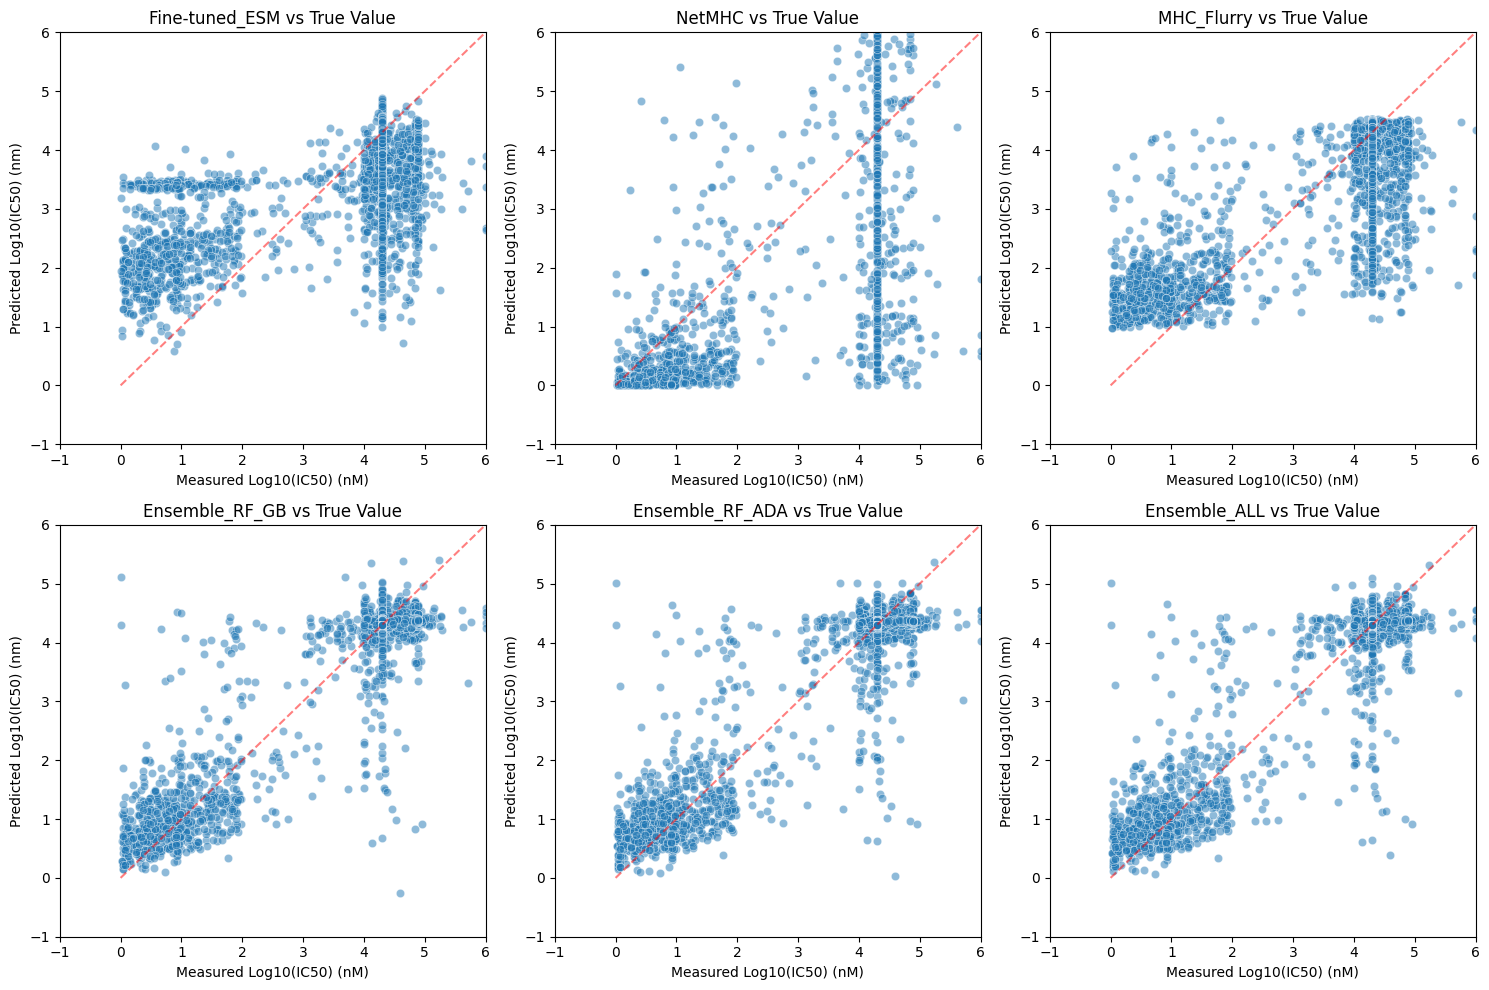

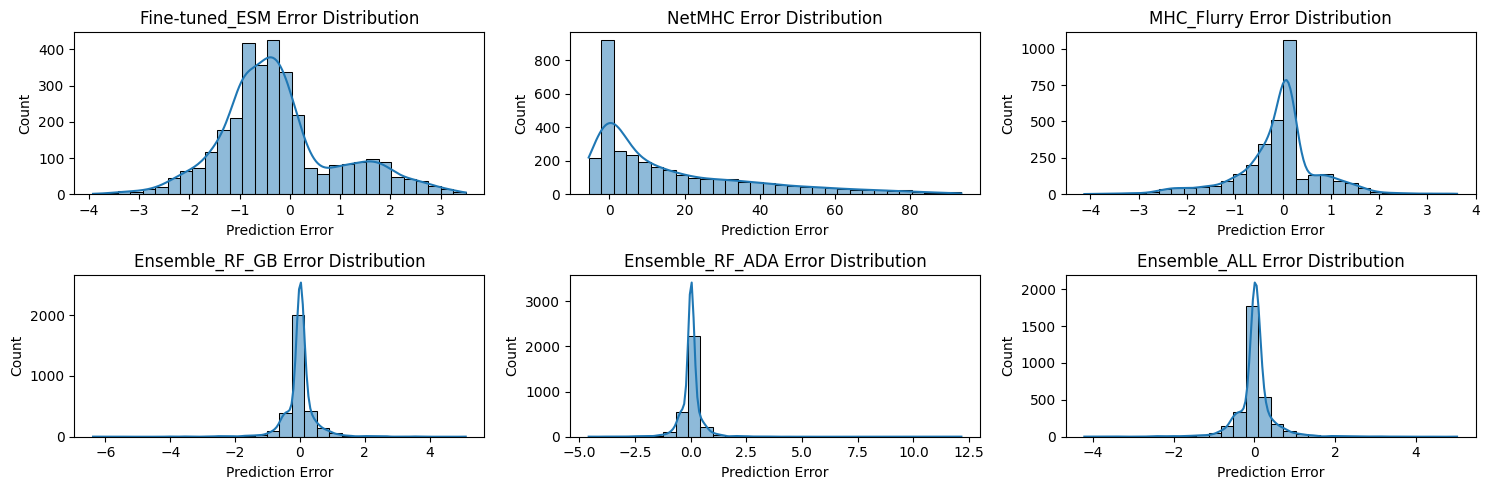

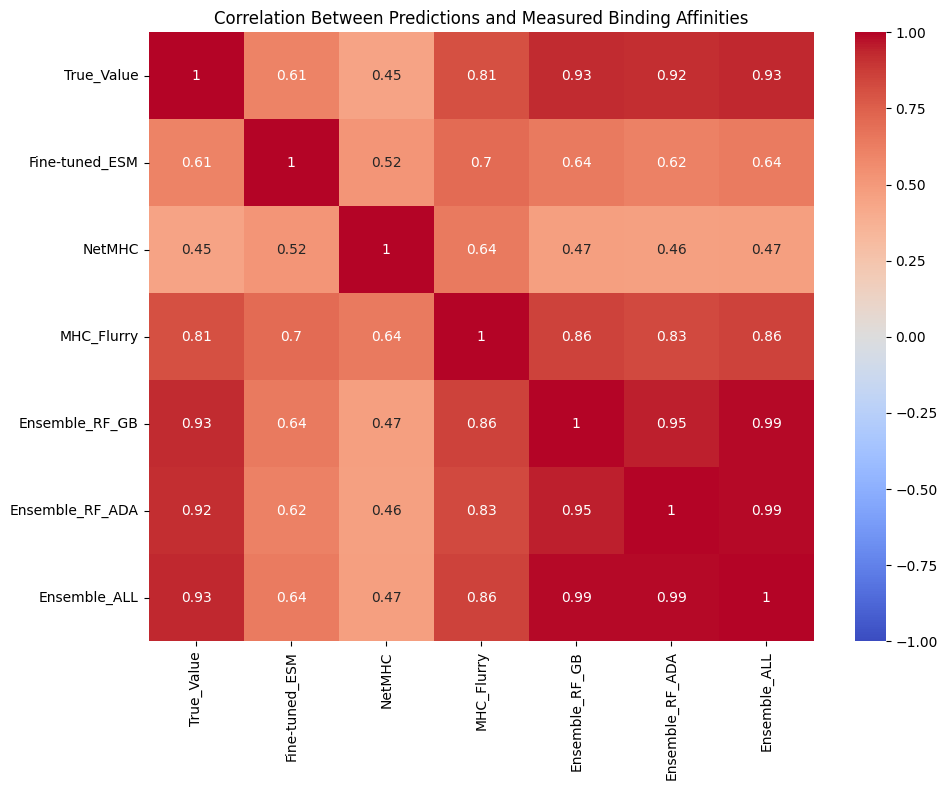

In [6]:
plot_scatter_matrix(plot_data, model_cols)
plot_error_distributions(plot_data, model_cols)
plot_correlation_heatmap(plot_data, model_cols)

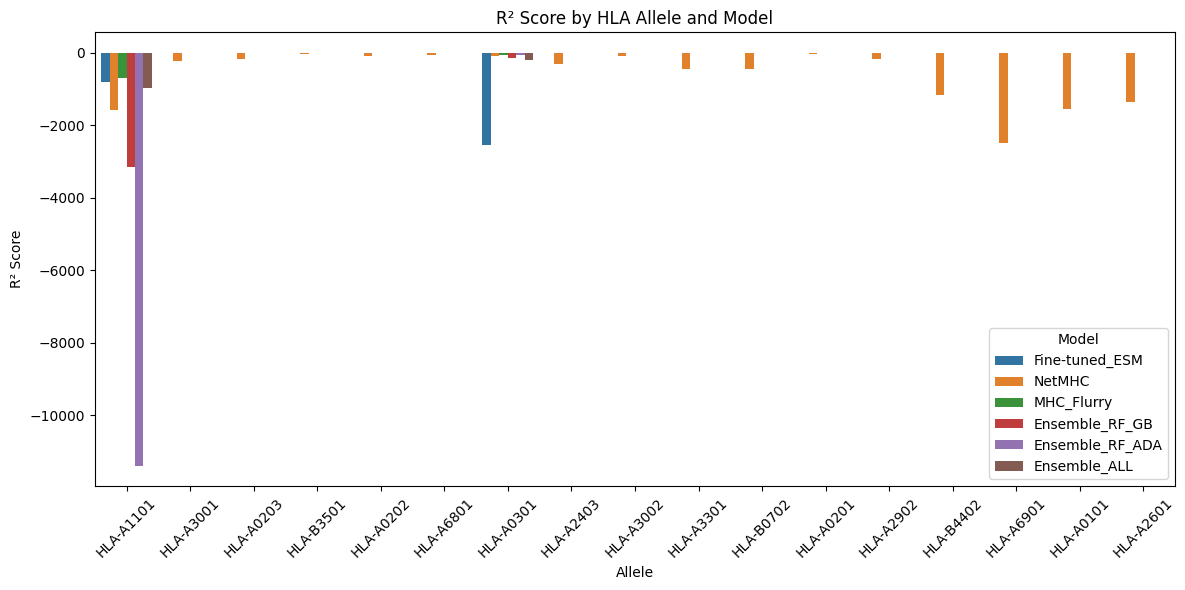

In [20]:
metrics = []
for allele in plot_data['Allele'].unique():
    allele_data = plot_data[plot_data['Allele'] == allele]
    for model in model_cols:
        r2 = r2_score(allele_data['True_Value'], allele_data[model])
        metrics.append({'Allele': allele, 'Model': model, 'R2': r2})
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='Allele', y='R2', hue='Model')
plt.title('R² Score by HLA Allele and Model')
plt.xticks(rotation=45)
plt.ylabel('R² Score')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('r2_by_allele.png')
plt.show()

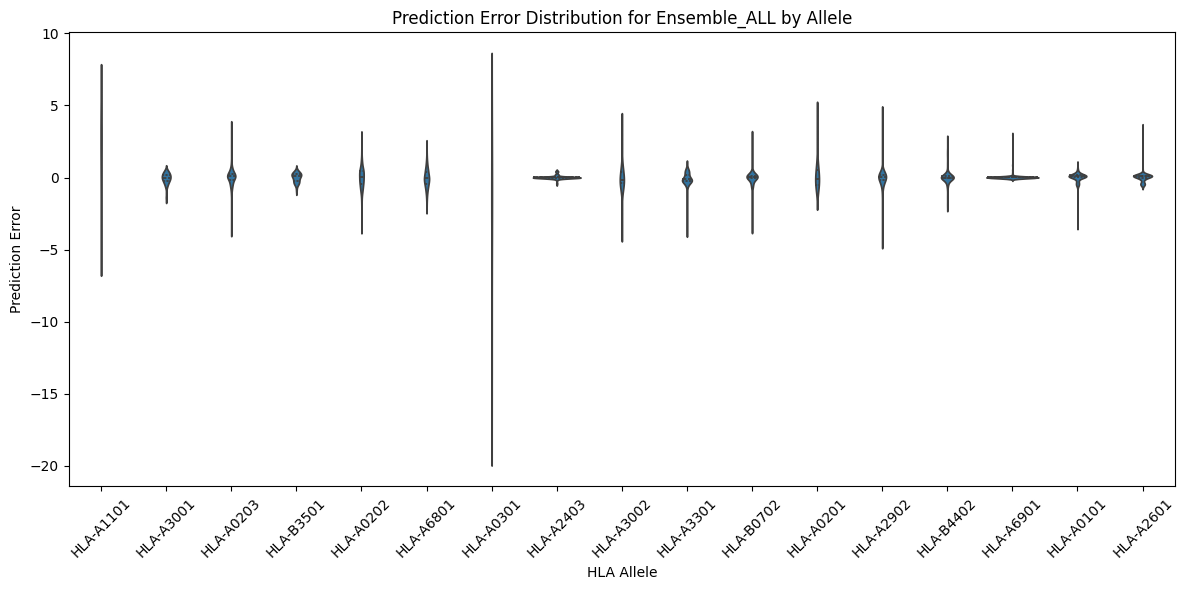

In [21]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=plot_data, x='Allele', y=plot_data['Ensemble_ALL'] - plot_data['True_Value'], inner='quartile')
plt.title('Prediction Error Distribution for Ensemble_ALL by Allele')
plt.xlabel('HLA Allele')
plt.ylabel('Prediction Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('error_violin_by_allele.png')
plt.show()

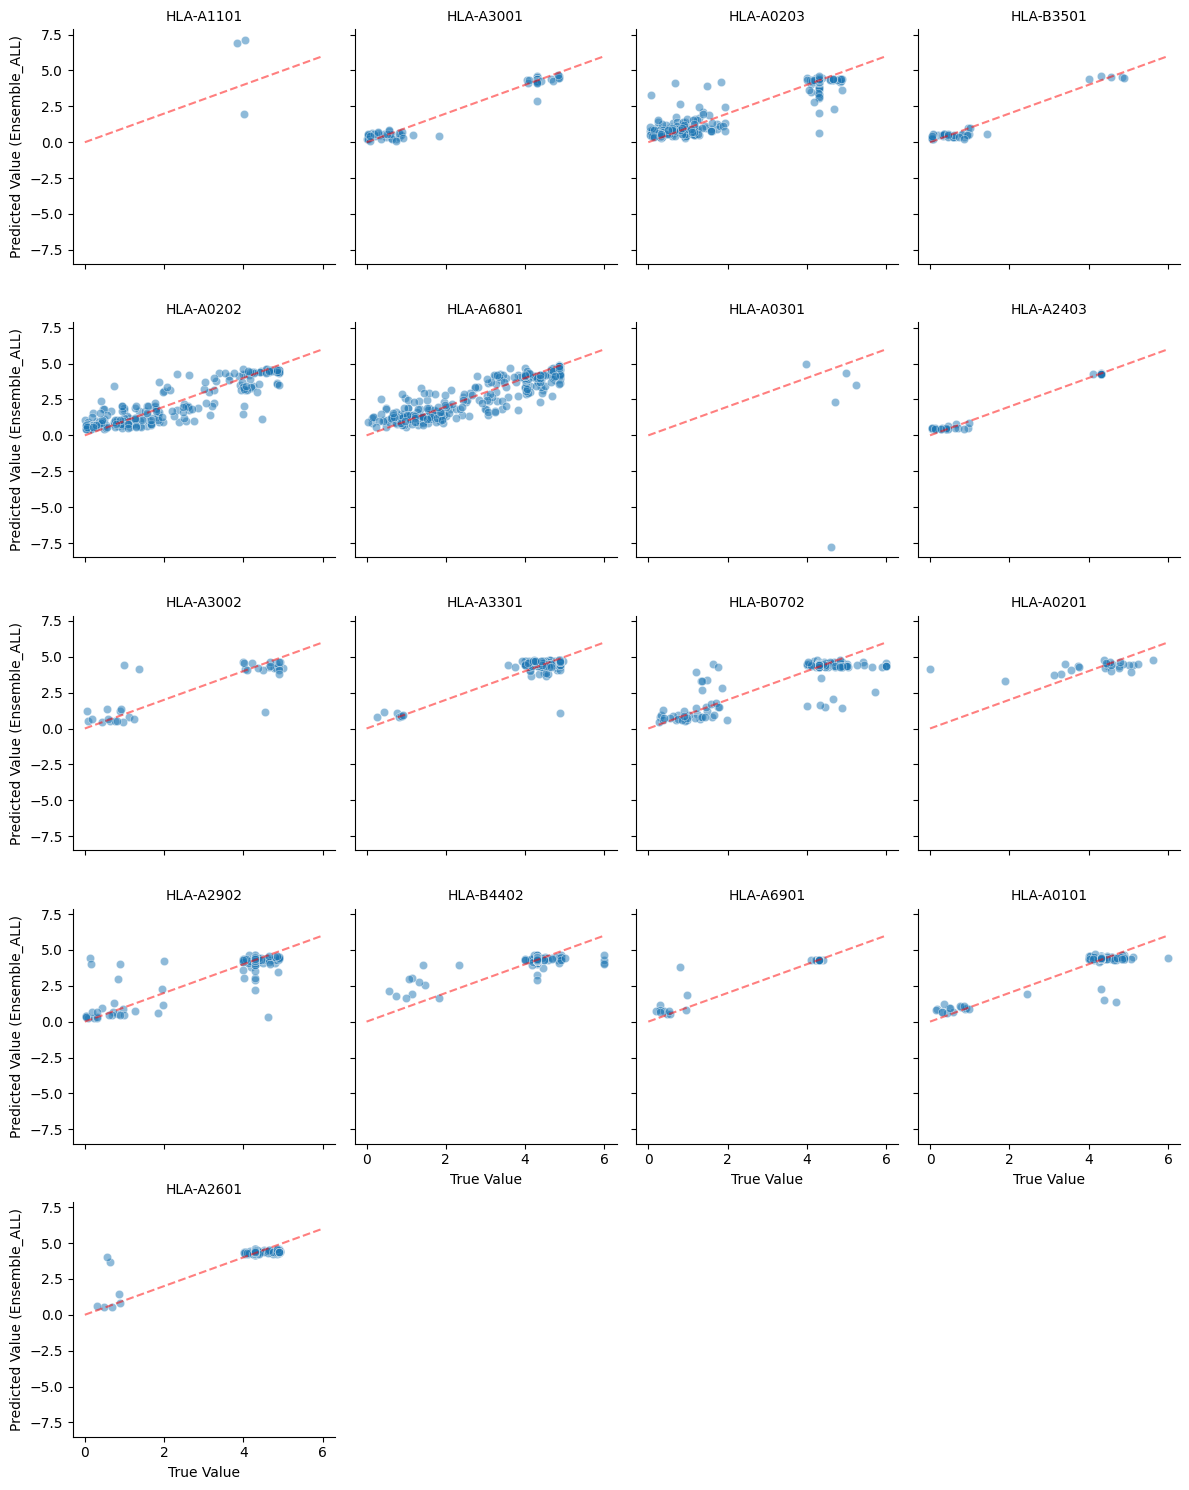

In [22]:
g = sns.FacetGrid(plot_data, col='Allele', col_wrap=4, height=3)
g.map(sns.scatterplot, 'True_Value', 'Ensemble_ALL', alpha=0.5)
g.map(lambda x, y, **kw: plt.plot([0, 6], [0, 6], 'r--', alpha=0.5), 'True_Value', 'Ensemble_ALL')
g.set_titles('{col_name}')
g.set_axis_labels('True Value', 'Predicted Value (Ensemble_ALL)')
plt.tight_layout()
plt.savefig('scatter_by_allele_ensemble_all.png')
plt.show()